In [390]:
# I load standard packages I know I'll need for exploratory data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set default figure size for plots
plt.rcParams["figure.figsize"] = [12, 8]

In [391]:
# read in the data
temperature_data = pd.read_csv("sample_temperature_data_for_coding_challenge.csv")

In [392]:
# get an idea what is in the data set
temperature_data.head()

,source_id,datetime,property_name,temperature
0,MICDEV001,2019-04-13T17:51:16.000+0000,heating_temperature,33.3
1,MICDEV001,2019-04-13T17:51:16.000+0000,cooling_temperature,15.0
2,MICDEV001,2019-04-13T18:51:18.000+0000,heating_temperature,34.0
3,MICDEV001,2019-04-13T19:51:20.000+0000,heating_temperature,33.8
4,MICDEV001,2019-04-13T20:51:21.000+0000,heating_temperature,34.2


In [393]:
# what types am I dealing with
temperature_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   source_id      1000 non-null   object 
 1   datetime       1000 non-null   object 
 2   property_name  1000 non-null   object 
 3   temperature    1000 non-null   float64
dtypes: float64(1), object(3)
memory usage: 31.4+ KB


In [394]:
temperature_data.source_id.value_counts()

source_id
MICDEV001    1000
Name: count, dtype: int64

--> all data comes from one and the same source: MICDEV001 --> could be dropped...

In [395]:
# the 'datetime' column, currently string format should be converted to datetime format
# and used as index column

temperature_data["datetime"] = pd.to_datetime(temperature_data["datetime"])
temperature_data.set_index("datetime", inplace=True)

In [396]:
temperature_data.index

DatetimeIndex(['2019-04-13 17:51:16+00:00', '2019-04-13 17:51:16+00:00',
               '2019-04-13 18:51:18+00:00', '2019-04-13 19:51:20+00:00',
               '2019-04-13 20:51:21+00:00', '2019-04-13 21:51:23+00:00',
               '2019-04-13 22:51:25+00:00', '2019-04-13 23:51:26+00:00',
               '2019-04-14 00:51:28+00:00', '2019-04-14 01:51:30+00:00',
               ...
               '2020-01-21 11:28:35+00:00', '2020-01-21 12:28:36+00:00',
               '2020-01-21 12:28:36+00:00', '2020-01-21 13:28:38+00:00',
               '2020-01-21 14:28:40+00:00', '2020-01-21 15:28:41+00:00',
               '2020-01-21 16:28:43+00:00', '2020-01-21 17:28:45+00:00',
               '2020-01-24 08:56:36+00:00', '2020-01-24 08:56:36+00:00'],
              dtype='datetime64[ns, UTC]', name='datetime', length=1000, freq=None)

In [397]:
frequency = temperature_data.index.inferred_freq
print(frequency)

None


Thoughts:
- The time stamps show no frequency, at least not down to the resolution of a second, but there might be intervalls every half an hour

--> check that later, or sample timestamp down to minute resolution

In [398]:
# how many different entries does "property_name" contain and which are they?

temperature_data.property_name.value_counts()

property_name
heating_temperature    699
cooling_temperature    301
Name: count, dtype: int64

Attention: the "temperature" column contains measurements of both HEATING and COOLING (different tags)

Imbalance between heating (70%) and cooling (30%) measurements

In [399]:
# create new columns for easier access
heating = temperature_data[
    temperature_data["property_name"] == "heating_temperature"
].copy()
cooling = temperature_data[
    temperature_data["property_name"] == "cooling_temperature"
].copy()

temperature_data["heating_temperature"] = heating["temperature"]
temperature_data["cooling_temperature"] = cooling["temperature"]

# new reduced dataframe
temperature_pivoted = temperature_data.copy()
temperature_pivoted = temperature_pivoted[
    ["heating_temperature", "cooling_temperature"]
]

In [400]:
temperature_pivoted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2019-04-13 17:51:16+00:00 to 2020-01-24 08:56:36+00:00
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   heating_temperature  983 non-null    float64
 1   cooling_temperature  585 non-null    float64
dtypes: float64(2)
memory usage: 23.4 KB


Text(0.5, 1.0, 'Heating and cooling temperatures over time')

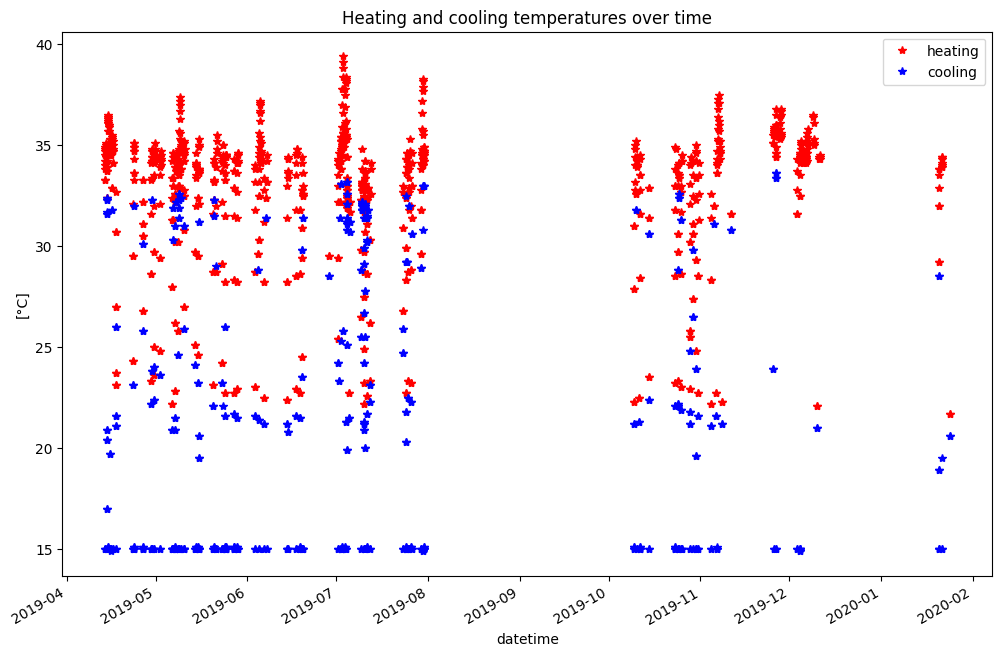

In [401]:
# Visualize and plot heating and cooling temperatures

temperature_pivoted["heating_temperature"].plot(style="*", c="r")
temperature_pivoted["cooling_temperature"].plot(style="*", c="b")

plt.legend(["heating", "cooling"])
plt.ylabel("[°C]")
plt.title("Heating and cooling temperatures over time")

#### Findings so far:
-   Temperature sensor data is taged and there are two categories, either "heating" or "cooling"
-   No knowledge what exactly heating or cooling refers to, maybe an industrial process...
-   70% of the data points contains heating temperatures
-   30% of the data points are cooling temperatures
-   both categories are sampled by the same sensor, gateway, device, etc. --> this is important if you argue about sensor/device failures 
-   Temperatures are sampled between April 2019 and February 2020. 
-   There is no data for September and October, no data for most of January/February 2020
-   Lots of 'cooling' temperatures are at 15°C
-   "Heating" temperature peaks show quasi cyclic behaviour (once a month) --> investigate that (or ask SME)

#### Thoughts:
-   Probably, it makes no sense to fill such long gaps of "missing" data. Moreover, I don't know if the data is even missing. Maybe the underlying industrial process was not running at these times, so no data was created at all.
-   I do not assume a malfunction of the sensor / device, where "cooling" is at 15°C, I assume the measurements at 15°C are correct.
-   Focus on correlation between "cooling" and "heating" (I highly assume they are somehow related via an underlying industrial process)
-   What types of anomalies could make sense? <br>
    -> min. / max. temperature anomaly ? <br>
    -> anomaly in correlation between "heating" and "cooling"? <br>
    -> temporal anomaly, i.e. peak values not at expected dates / times ?
    -> Something else ...?
     

Text(0.5, 1.0, 'Distirbution of heating and cooling temperatures')

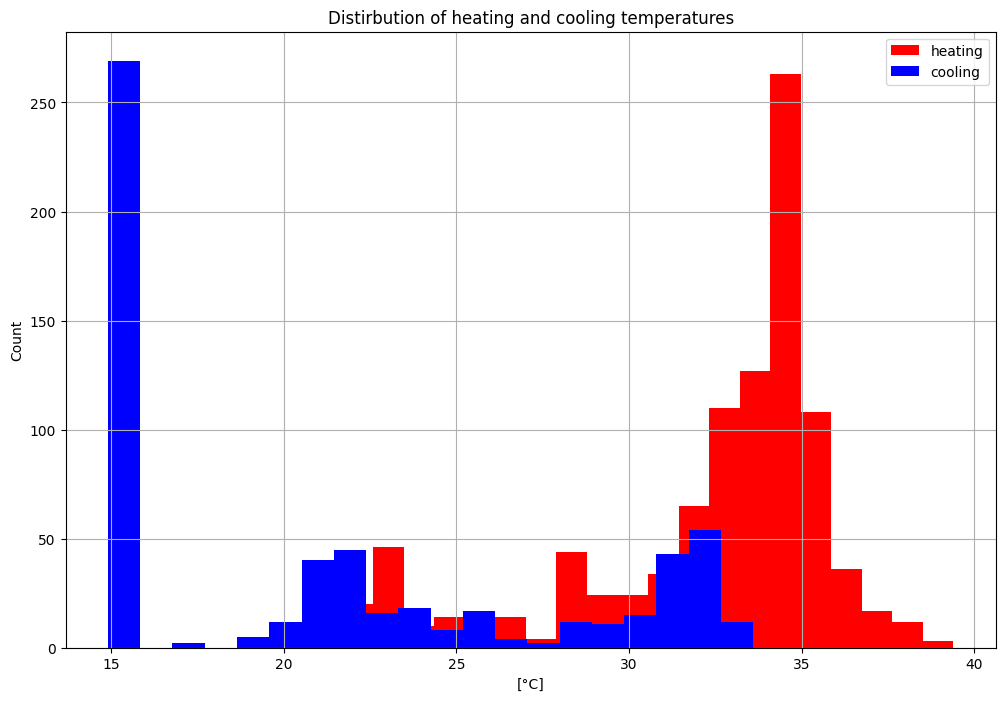

In [402]:
# show distirbution of "heating" and "cooling"
temperature_pivoted["heating_temperature"].hist(bins=20, color="r")
temperature_pivoted["cooling_temperature"].hist(bins=20, color="b")
plt.ylabel("Count")
plt.xlabel("[°C]")
plt.legend(["heating", "cooling"])
plt.title("Distirbution of heating and cooling temperatures")

Text(0, 0.5, '[°C]')

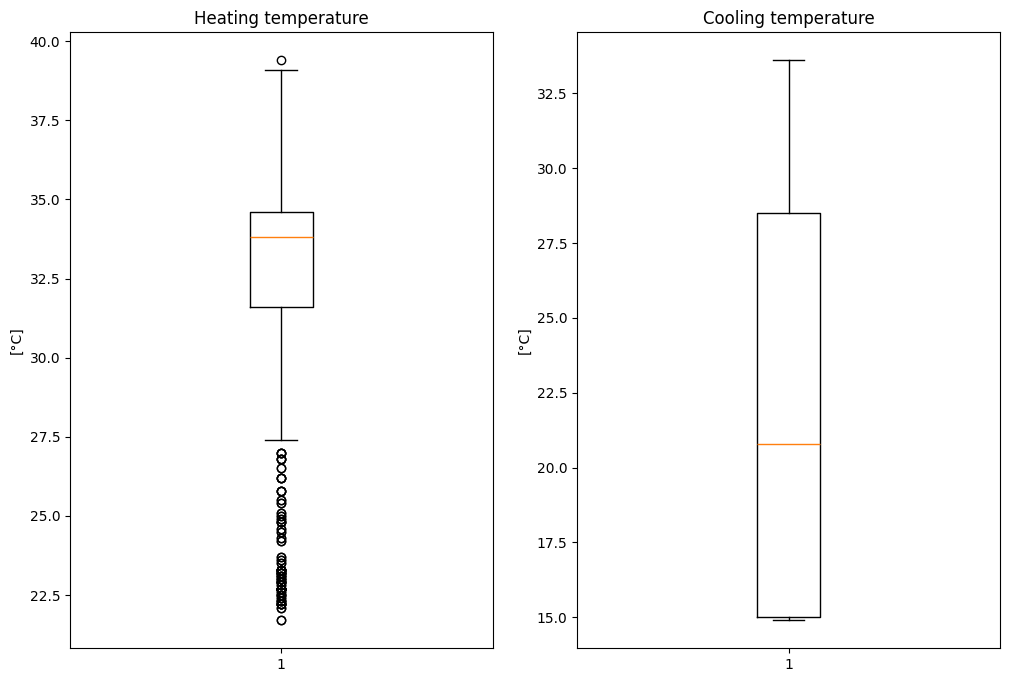

In [403]:
plt.subplot(1, 2, 1)
plt.boxplot(temperature_pivoted["heating_temperature"].dropna())
plt.title("Heating temperature")
plt.ylabel("[°C]")

plt.subplot(1, 2, 2)
plt.boxplot(temperature_pivoted["cooling_temperature"].dropna())
plt.title("Cooling temperature")
plt.ylabel("[°C]")

According to boxplots there are no real outliers in cooling_temperature. However, for heating, temperatures below 27.5°C are considered outliers (median temperature is ~34°C). --> Ask for domain knowledge if available. 

In [404]:
# filter where "cooling" and "heating" were recorded at exact same time stamp
# as we have more heating than cooling samples

mask = (temperature_pivoted["heating_temperature"].notna()) & (
    temperature_pivoted["cooling_temperature"].notna()
)

temperature_cooling_and_heating = temperature_pivoted.loc[mask].copy()

In [405]:
temperature_cooling_and_heating.head()

,heating_temperature,cooling_temperature
datetime,,
2019-04-13 17:51:16+00:00,33.3,15.0
2019-04-13 17:51:16+00:00,33.3,15.0
2019-04-14 10:25:16+00:00,34.2,20.9
2019-04-14 10:25:16+00:00,34.2,20.9
2019-04-14 10:43:38+00:00,34.5,20.4


In [406]:
# some duplicates in the data: drop these
temperature_cooling_and_heating.drop_duplicates(inplace=True)

In [407]:
print(f"Timestamps with samples in temperature_pivoted: {len(temperature_pivoted)}")
print(
    f"Timestamps with samples in temperature_cooling_and_heating: {len(temperature_cooling_and_heating)}"
)

Timestamps with samples in temperature_pivoted: 1000
Timestamps with samples in temperature_cooling_and_heating: 218


Text(0.5, 1.0, 'Heating and cooling temperatures over time, mutual cooling and heating')

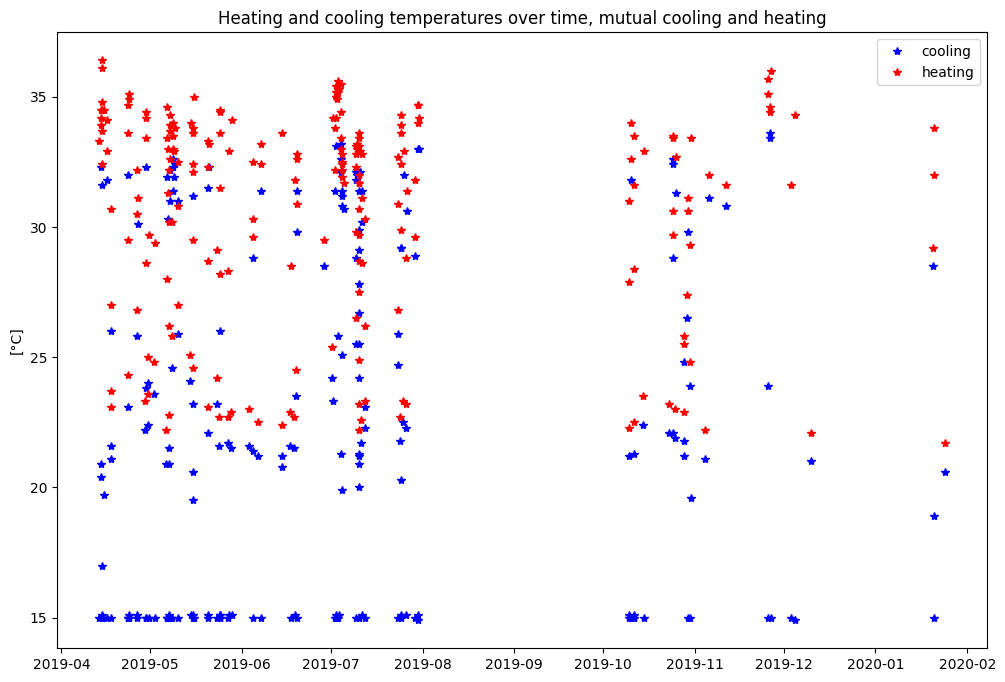

In [408]:
plt.plot(temperature_cooling_and_heating["cooling_temperature"], "*b")
plt.plot(temperature_cooling_and_heating["heating_temperature"], "*r")
plt.ylabel("[°C]")
plt.legend(["cooling", "heating"])
plt.title("Heating and cooling temperatures over time, mutual cooling and heating")

Text(0.5, 1.0, 'Distirbution of heating and cooling temperatures')

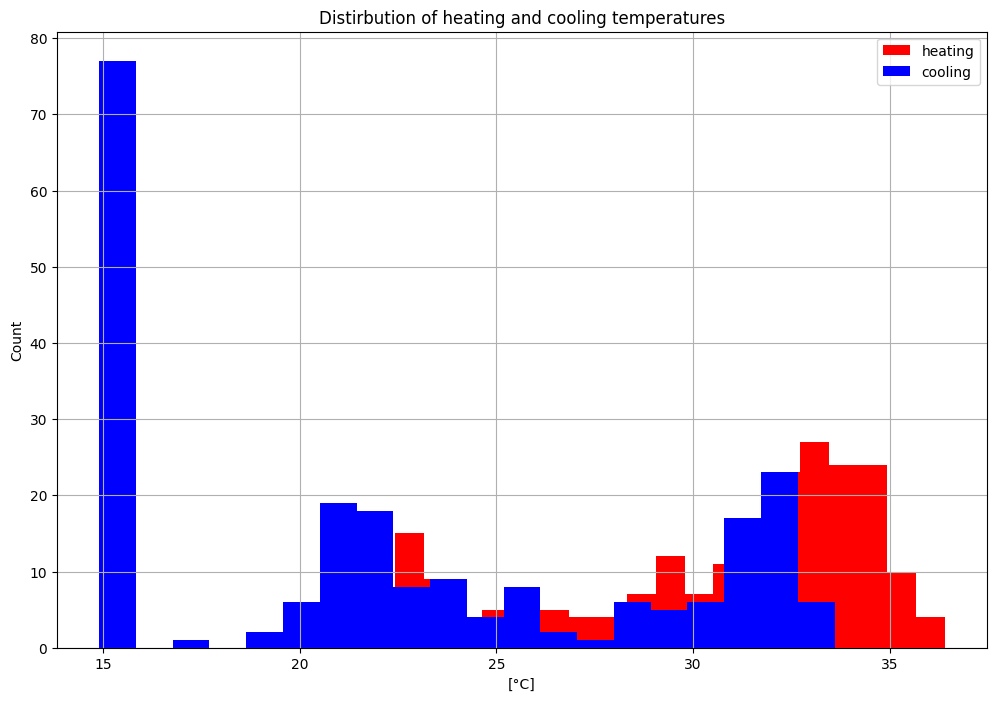

In [409]:
# show distirbution of "heating" and "cooling"
temperature_cooling_and_heating["heating_temperature"].hist(bins=20, color="r")
temperature_cooling_and_heating["cooling_temperature"].hist(bins=20, color="b")
plt.ylabel("Count")
plt.xlabel("[°C]")
plt.legend(["heating", "cooling"])
plt.title("Distirbution of heating and cooling temperatures")

#### Observation: 
the high heating temperatures seem to be missing here (above 35°C) <br>
In other words, for high (>35°C) heating temperatures, there's missing a sample of "cooling" temperature <br> 
-> at least at the very same second. Explanation could be: At high "heating" temperatures the sample rate of this data increases, while "cooling" stays rather constant and is not sampled at the same rate (to save bandwidth, storage, etc.) -> check that later on!

Text(0.5, 1.0, 'Correlation between cooling and heating temperatures')

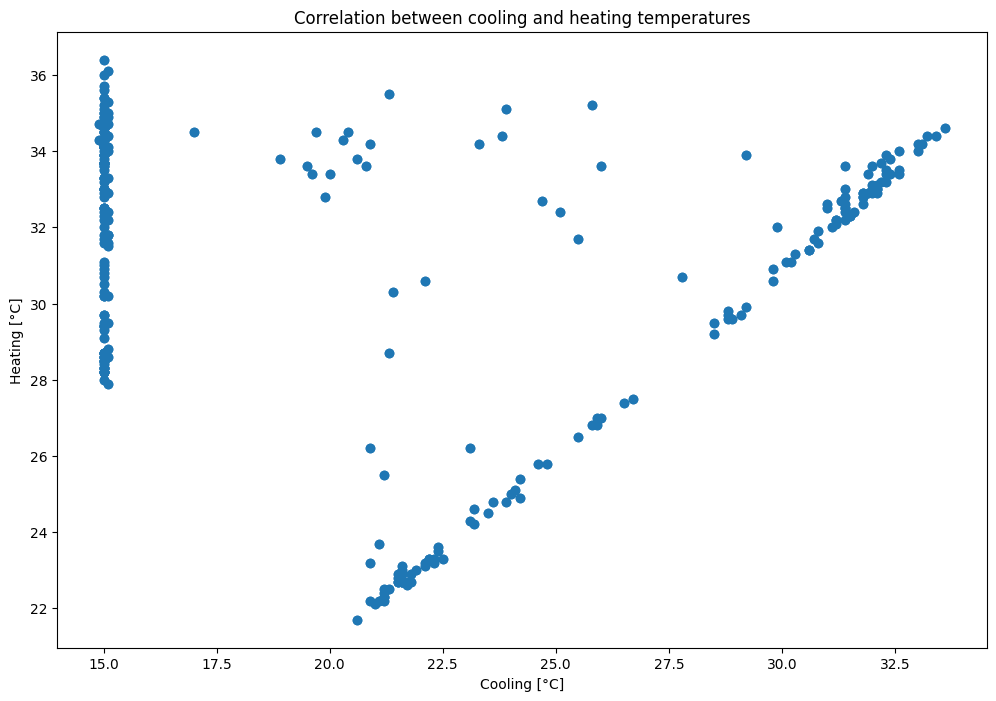

In [410]:
plt.scatter(
    temperature_pivoted.cooling_temperature, temperature_pivoted.heating_temperature
)
plt.xlabel("Cooling [°C]")
plt.ylabel("Heating [°C]")
plt.title("Correlation between cooling and heating temperatures")

#### Findings:
- At cooling temperature ~15°C there can be observed heating temperatures from 28 - 36°C
- For heating temperatures < 27.5°C there's no constant cooling temperature at 15°C. They are all higher. --> That goes back to outliers from boxplot.
- For cooling temperatures from < 20°C cooling and heating seem to have a linear relation, however, there are outliers --> Anomaly?

Ideas: use DBSCAN rather than K-Means for clustering and devising groups; try also Isolation Forest

#### Next, I'm interested in the remaining data, where heating has no coresponding cooling temperature (i.e. where cooling is NaN)

In [411]:
# where are NaNs in cooling and heating?

# randomly inspecting the temperatures
temperature_pivoted.loc["2019-05-07":"2019-05-10"].drop_duplicates()

,heating_temperature,cooling_temperature
datetime,,
2019-05-07 09:04:49+00:00,22.8,21.5
2019-05-07 09:37:06+00:00,26.2,20.9
2019-05-07 10:37:08+00:00,30.2,15.1
2019-05-07 11:37:10+00:00,32.2,15.0
2019-05-07 13:14:51+00:00,32.6,31.0
2019-05-07 14:14:52+00:00,33.9,15.0
2019-05-07 15:14:54+00:00,34.5,NaN
2019-05-07 16:14:56+00:00,34.4,NaN
2019-05-07 17:32:18+00:00,33.7,32.2


#### Observation and assumption
From what I observe: NaNs in cooling_temperature appear mostly after 15.0°C for several timestamps. However, that's not always the case. 

I do make an assumption here: <br> 
From my experience with sensors, I know that there are sensors and settings where the device only transmits a value if there is a change compared to the last measured value. If the measured value has not changed, the last transmitted value is valid. So, I do not assume a sensor failure (hot and cool are both measured by MICDEV001) and would assume I can replace the NaNs with a forward fill. <br>
In reality I would discuss this with domain experts who know about the sensor settings.

In [412]:
# label (0,1) where there were NaNs originally
temperature_pivoted["was_NaN_cooling"] = (
    temperature_pivoted["cooling_temperature"].isna().astype(int)
)
temperature_pivoted["was_NaN_heating"] = (
    temperature_pivoted["heating_temperature"].isna().astype(int)
)

In [413]:
# forward fill
temperature_pivoted["cooling_temperature"] = temperature_pivoted[
    "cooling_temperature"
].ffill()
temperature_pivoted["heating_temperature"] = temperature_pivoted[
    "heating_temperature"
].ffill()

In [414]:
temperature_pivoted.head(10)

,heating_temperature,cooling_temperature,was_NaN_cooling,was_NaN_heating
datetime,,,,
2019-04-13 17:51:16+00:00,33.3,15.0,0,0
2019-04-13 17:51:16+00:00,33.3,15.0,0,0
2019-04-13 18:51:18+00:00,34.0,15.0,1,0
2019-04-13 19:51:20+00:00,33.8,15.0,1,0
2019-04-13 20:51:21+00:00,34.2,15.0,1,0
2019-04-13 21:51:23+00:00,34.5,15.0,1,0
2019-04-13 22:51:25+00:00,34.7,15.0,1,0
2019-04-13 23:51:26+00:00,34.8,15.0,1,0
2019-04-14 00:51:28+00:00,34.9,15.0,1,0


In [415]:
temperature_pivoted.drop_duplicates(inplace=True)

In [416]:
# what is the average temperature I have replaced in cooling_temperature
temperature_pivoted[temperature_pivoted["was_NaN_cooling"] == 1][
    "cooling_temperature"
].describe()

count    82.000000
mean     16.008537
std       3.626215
min      15.000000
25%      15.000000
50%      15.000000
75%      15.000000
max      31.500000
Name: cooling_temperature, dtype: float64

Text(0, 0.5, '[°C]')

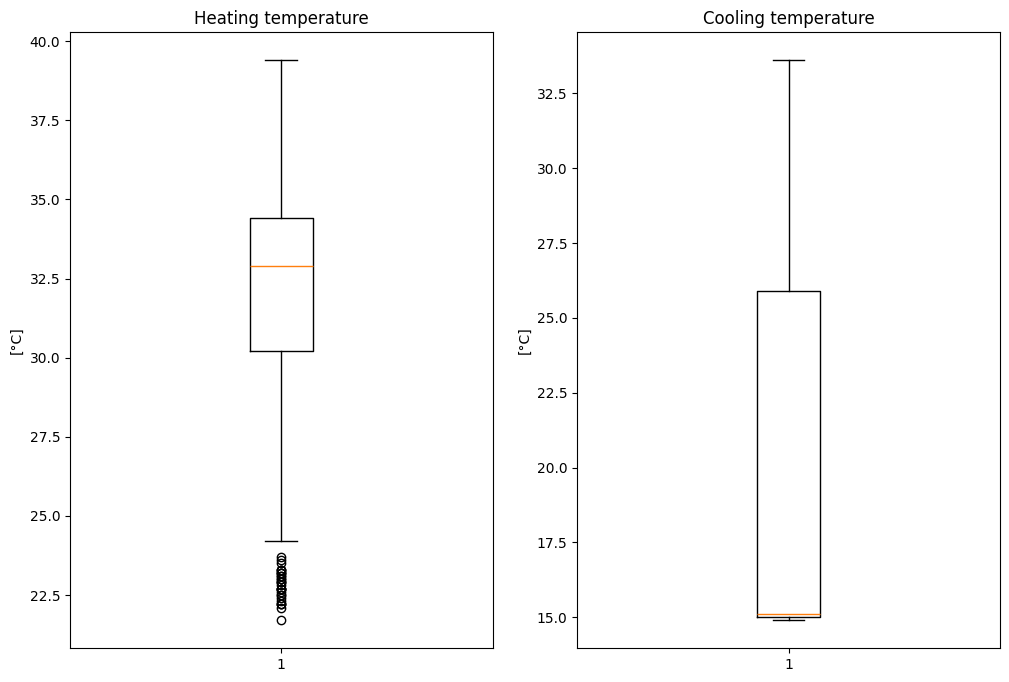

In [417]:
# How did the quartiles change through the ffill?

plt.subplot(1, 2, 1)
plt.boxplot(temperature_pivoted["heating_temperature"])
plt.title("Heating temperature")
plt.ylabel("[°C]")

plt.subplot(1, 2, 2)
plt.boxplot(temperature_pivoted["cooling_temperature"])
plt.title("Cooling temperature")
plt.ylabel("[°C]")

- Outliers in heating_temperature are now below 25°C (before 27.5°C)
- No real outliers in cooling_temperature. 

Text(0.5, 1.0, 'Correlation between cooling and heating temperatures')

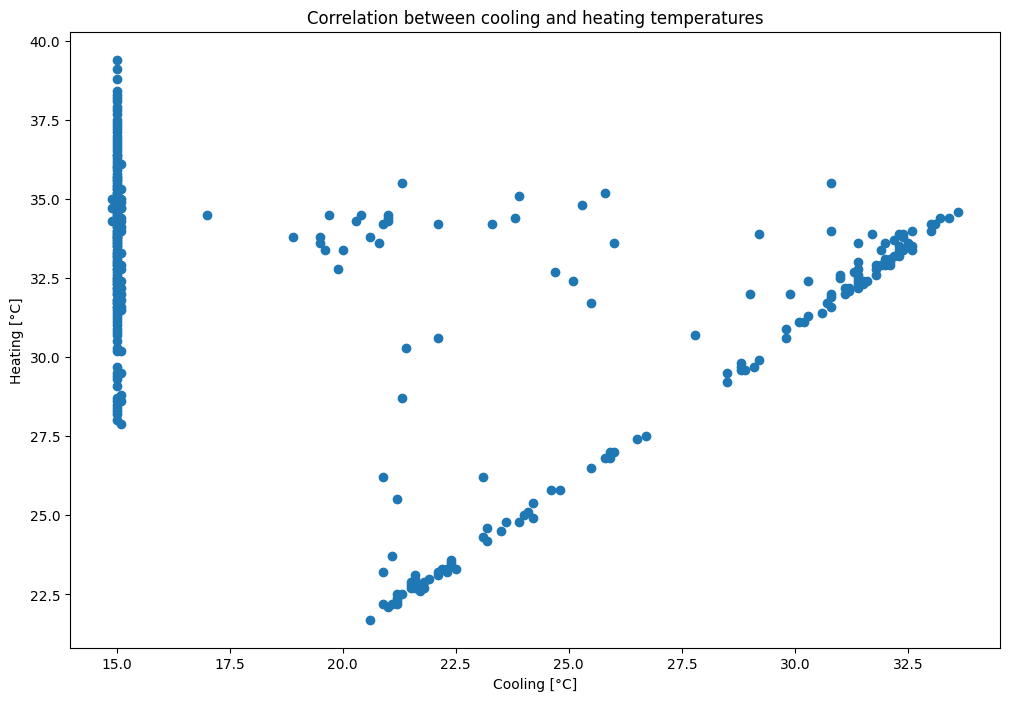

In [418]:
# Have a look again at correlation between heating and cooling
plt.scatter(
    temperature_pivoted.cooling_temperature, temperature_pivoted.heating_temperature
)
plt.xlabel("Cooling [°C]")
plt.ylabel("Heating [°C]")
plt.title("Correlation between cooling and heating temperatures")

Nothing really changed compared to previous scatter plot. However, higher heating_temperatures at 15°C cooling.

#### Ideas for an anomaly detection case

Before comming up with a detection model I'd be interested in more background information from SMEs. E.g., how is heating and cooling related, what is it used for? Is there any process that uses / generates these temperatures? Can we relate the state of this process (e.g., category: good / bad or metric: 100% perfect) to the temperatures and lable the data? An anomaly could also be a too high or to low temperature for either cooling or heating.

Since I don't have this information I assume:
- Any data points where cooling_temperature is ~15°C I would assume to be ok (no anomaly). This applies to about 50% of the data set.
- For higher cooling temperatures there seems to be a linear relation between cooling and heating (T_heating =~ T_cooling + 1°C). --> Points that deviate from the regression line are considered outliers.
- Use clustering methods and see if they find points which do not belong to a certain cluster / group.

In [419]:
def linear_heating_tempeature(X: np.ndarray) -> np.ndarray:
    """returns temperature y array for given input temperature X array.
    Output temperature is 1°C higher than input temperature.
    """
    y = X + 1
    return y

In [420]:
# y_pred = linear_heating_tempeature(np.linspace(20, 33))

In [421]:
def anomaly_detection_linear_relation(
    temperature_data: pd.DataFrame, cooling_thershold: float, tolerance: float
) -> pd.DataFrame:
    """flags cooling and heating temperature pairs as anomaly based on cooling_threshold and tolerance criteria.

    Args:
        temperature_data (pd.DataFrame): input dataframe with "cooling_temperature" and "heating_temperature" columns.
        cooling_thershold (float): all samples with a cooling_temperature below this threshold are excluded from anomaly analysis.
        tolerance (float): differenc in [°C] between measured heating_temperature and linear regression above which a
        temperature sample is considered an anomaly

    Returns:
        pd.DataFrame: input dataframe with additional "anomaly" column
    """

    data_subset = temperature_data[
        temperature_data["cooling_temperature"] > cooling_thershold
    ].copy()

    data_subset["y_pred_linear"] = linear_heating_tempeature(
        data_subset["cooling_temperature"]
    )

    # flag anomaly based on tolerance criteria for linear relation
    data_subset.loc[
        abs(data_subset["heating_temperature"] - data_subset["y_pred_linear"])
        > tolerance,
        "anomaly",
    ] = 1

    temperature_data["anomaly"] = data_subset["anomaly"]
    temperature_data["anomaly"] = temperature_data["anomaly"].fillna(0).astype(int)

    return temperature_data

In [422]:
# if samples are flaged as anomaly is highly dependant on cooling_threshold and tolerance. Values are educated guesses.

data_anomaly = anomaly_detection_linear_relation(
    temperature_pivoted, cooling_thershold=15.2, tolerance=1
)

In [423]:
data_anomaly.head()

,heating_temperature,cooling_temperature,was_NaN_cooling,was_NaN_heating,anomaly
datetime,,,,,
2019-04-13 17:51:16+00:00,33.3,15.0,0,0,0
2019-04-13 18:51:18+00:00,34.0,15.0,1,0,0
2019-04-13 19:51:20+00:00,33.8,15.0,1,0,0
2019-04-13 20:51:21+00:00,34.2,15.0,1,0,0
2019-04-13 21:51:23+00:00,34.5,15.0,1,0,0


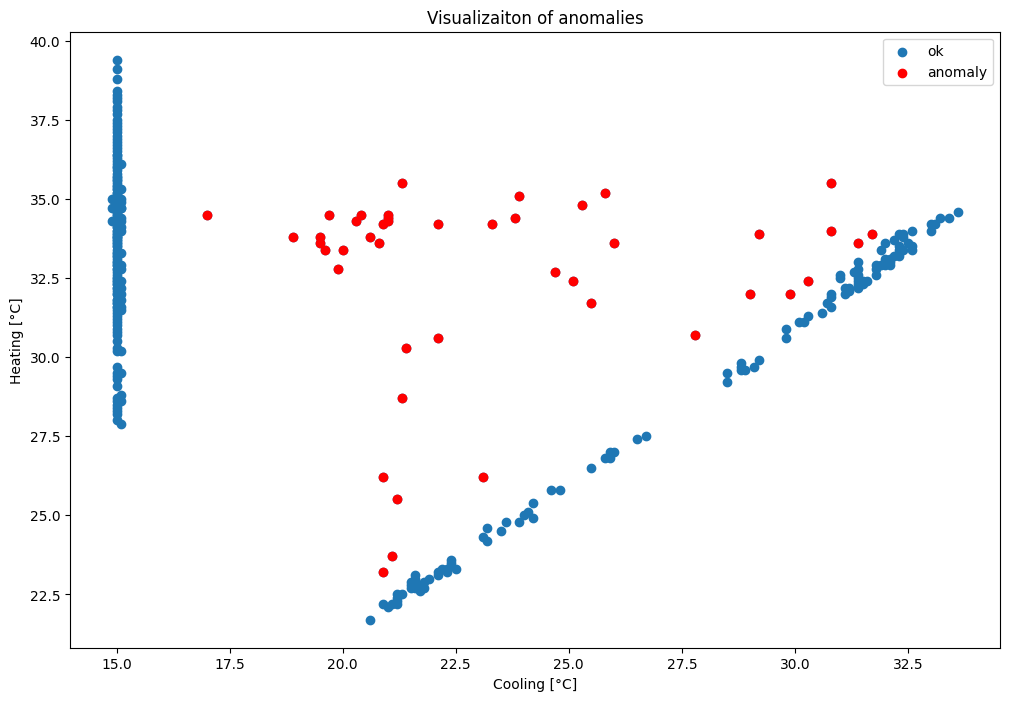

In [424]:
# Have a look again at correlation plot with anomalies
plt.scatter(data_anomaly.cooling_temperature, data_anomaly.heating_temperature)
plt.scatter(
    data_anomaly[data_anomaly["anomaly"] == 1]["cooling_temperature"],
    data_anomaly[data_anomaly["anomaly"] == 1]["heating_temperature"],
    c="r",
)
# plt.plot(np.linspace(20, 33), y_pred, "k")
plt.xlabel("Cooling [°C]")
plt.ylabel("Heating [°C]")
plt.title("Visualizaiton of anomalies")
plt.legend(["ok", "anomaly"])

From visual inspection outliers (which are neither at constant cooling temperature of 15°C, nor follow a quasi linear relation between heating and cooling) are detected very well. 

##### DBSCAN
DBSCAN (rather than K-Means) should also be able to identify outliers from the given data set. 

In [425]:
from sklearn.cluster import DBSCAN

# hyperparameters eps and min_samples -> trial and error: eps = 0.5 and min_samples = 5 seem to be a good choice
dbscan = DBSCAN(eps=0.5, min_samples=5)

dbscan.fit(data_anomaly[["heating_temperature", "cooling_temperature"]])

DBSCAN()

In [426]:
# labels = -1 are not assigned to any group --> outlier
outlier_loc = np.where(dbscan.labels_ == -1)
outlier_index = data_anomaly.iloc[outlier_loc].index

data_anomaly["dbscan_anomaly"] = 0
data_anomaly.loc[outlier_index, "dbscan_anomaly"] = 1

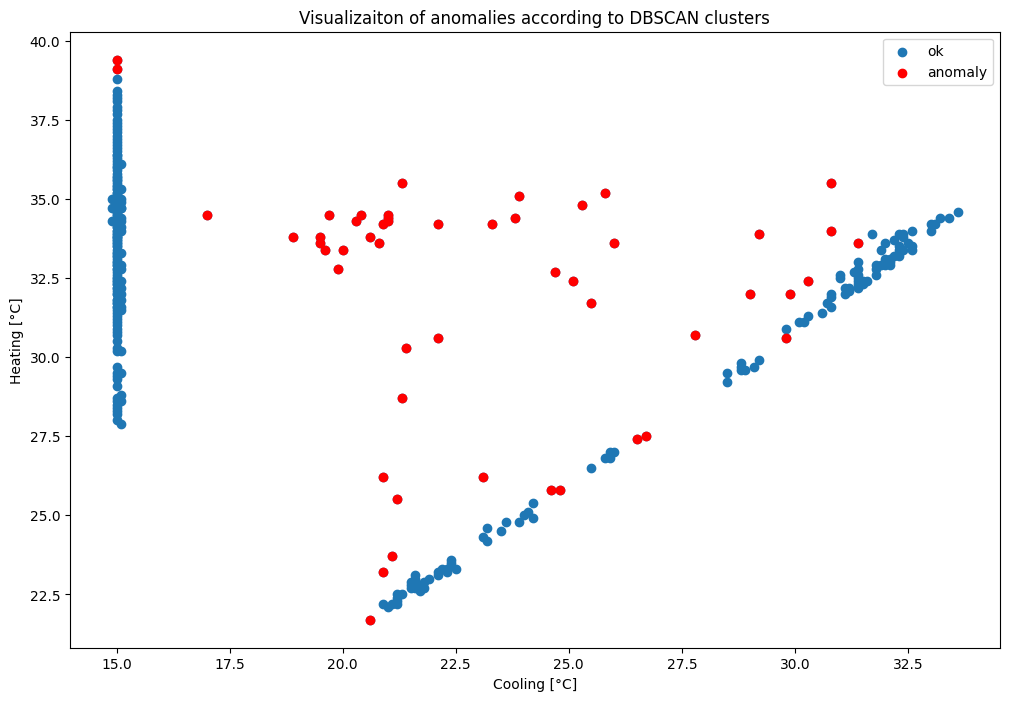

In [427]:
# Have a look again at correlation plot with anomalies
plt.scatter(data_anomaly.cooling_temperature, data_anomaly.heating_temperature)
plt.scatter(
    data_anomaly[data_anomaly["dbscan_anomaly"] == 1]["cooling_temperature"],
    data_anomaly[data_anomaly["dbscan_anomaly"] == 1]["heating_temperature"],
    c="r",
)
# plt.plot(np.linspace(20, 33), y_pred, "k")
plt.xlabel("Cooling [°C]")
plt.ylabel("Heating [°C]")
plt.title("Visualizaiton of anomalies according to DBSCAN clusters")
plt.legend(["ok", "anomaly"])

DBSCAN with right choice of hyperparameters is also suitable to detect outliers / anomalies. Other approaches could also include SVM or isolation forest. However, a reliable anomaly detection model requires a deeper understanding of the data. How is the data generated, how are cooling and heating related, what are negative effects asscoiated with anomalies in the temperatures, etc.

If "labels" were available, accuracy, precision and recall of the classifier could be computed (to quantify the quality of the model).